# Geo-Visualization Example Notebook

Welcome to the `Geo-Visualization Example` notebook! This notebook is designed to guide you through the process of visualizing geographical data from the Regionalstatistik database using Python and pystatis as API wrapper.

## Libraries Overview
In this notebook, we will require the following additional libraries:

- GeoPandas: An open-source project that makes working with geospatial data in python easier. It extends the datatypes used by pandas to allow spatial operations on geometric types. GeoPandas enables us to work with geospatial data in Python similarly to how we work with pandas for regular data.

- Matplotlib: A comprehensive library for creating static, animated, and interactive visualizations in Python. It is a multi-platform data visualization library built on NumPy arrays and designed to work with the broader SciPy stack.

You can install these libraries via pip using the following commands:

```bash
!pip install geopandas matplotlib
```

In [ ]:
# !pip install geopandas matplotlib

#### Import Required Libraries

In [1]:
import geopandas
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pystatis import Table

## Visualization on the Level of Bundesländer

In this first example, we will visualize the ratio of international students among students on the level of the Bundesländer. We will use the table with code `21311-01-01-4` from the Regionalstatistik API for the student data and `12411-01-01-4` for the population data. You can find the data by either search on the website or use the `Find` class which we also provide in `pystatis` to skim through the available data.

But first of all, we need to load the map of Germany which we already provide in the repository (Source: [BKG](https://gdz.bkg.bund.de/index.php/default/digitale-geodaten/verwaltungsgebiete/verwaltungsgebiete-1-2-500-000-stand-31-12-vg2500-12-31.html)). The geopandas library provides a convenient way to load shapefiles. We can load the shapefile of Germany using the `geopandas.read_file()` function.

In [2]:
# load Bundesländer geopandas shapefile
path_to_data = "data/VG2500_LAN.shp"
gdf = geopandas.read_file(path_to_data)

Geopandas also conveniently loads a bunch of associated metadata such as `area` and provides a `plot()` function that allows us to plot the map of Germany.

Example metadata are the `GEN` (name of the federal state or shape), `AGS` ([amtlicher Gemeindeschlüssel](https://datengui.de/statistik-erklaert/ags)) columns printed below as well as `CRS` information on the used coordinate frame.

In [3]:
gdf.GEN

0               Schleswig-Holstein
1                          Hamburg
2                    Niedersachsen
3                           Bremen
4              Nordrhein-Westfalen
5                           Hessen
6                  Rheinland-Pfalz
7                Baden-Württemberg
8                           Bayern
9                         Saarland
10                          Berlin
11                     Brandenburg
12          Mecklenburg-Vorpommern
13                         Sachsen
14                  Sachsen-Anhalt
15                       Thüringen
16              Schleswig-Holstein
17                         Hamburg
18                   Niedersachsen
19                   Niedersachsen
20                          Bremen
21          Mecklenburg-Vorpommern
22    Baden-Württemberg (Bodensee)
23               Bayern (Bodensee)
Name: GEN, dtype: object

In [4]:
gdf.AGS

0     01
1     02
2     03
3     04
4     05
5     06
6     07
7     08
8     09
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    01
17    02
18    03
19    03
20    04
21    13
22    08
23    09
Name: AGS, dtype: object

In [6]:
gdf.crs

<Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.01, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

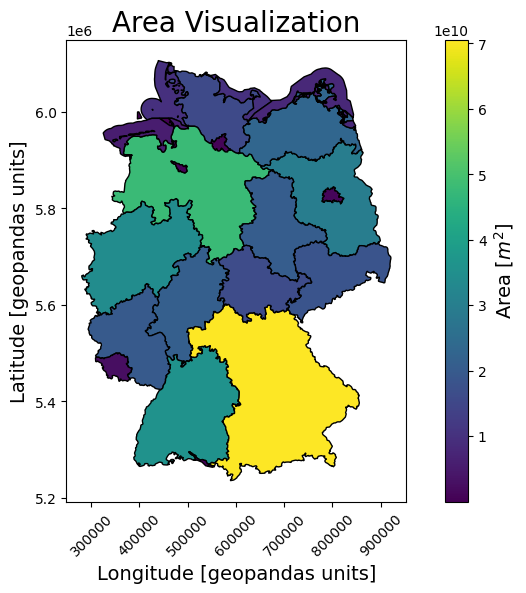

In [5]:
# plot the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
gdf.plot(column=gdf.area, legend=True, ax=ax, cmap="viridis", edgecolor="black")

# add titles and labels
ax.set_title("Area Visualization", fontsize=20)
ax.set_xlabel("Longitude [geopandas units]", fontsize=14)
ax.set_ylabel("Latitude [geopandas units]", fontsize=14)

# rotate x-axis labels to 45 degrees
plt.xticks(rotation=45)

# customize the colorbar
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel(r"Area [$m^2$]", fontsize=14)

plt.show()

### Load Regionalstatistik Data

To now fill the map with our tables of interest, we need to query the data from the Regionalstatistik API. We will use our the `pystatis` library - more specifically the `Table` class - to query the data.

In [6]:
students = Table(name="21311-01-01-4")
population = Table(name="12411-01-01-4")

Querying the data does not require any parameters, however, the data can be filtered by e.g. `startyear` or can be queried in a specific `language` (default is German, further supported language is English).

If the data is too large to be directly available via the API, we automatically start a so-called job to tell the API that we would like to wait until the data is processed in the background and ready to be downloaded - and download it for you automatically.

**Warning**: The following code might run a while, most of the runtime is waiting for the API to deliver the data so take a break and drink some tea!

In [7]:
students.get_data(startyear=2015)
population.get_data()

Die Tabelle ist zu groß, um direkt abgerufen zu werden. Es wird eine Verarbeitung im Hintergrund gestartet.


### Process Students Data

To determine the ratio of international students among students per year and region we need to first filter the data for the relevant columns. We will then merge the two tables and calculate the ratio of international students among students.

In [8]:
# define the filters in the relevant columns
total_sex = students.data.Geschlecht == "Insgesamt"
all_subjects = students.data["Fächergruppe (mit Insgesamt)"] == "Insgesamt"

# filter and display example subselection of the data
df = students.data[total_sex & all_subjects]
df[(df["Amtlicher Gemeindeschlüssel (AGS)"] == "07131") & (df["Semester"] == "WS 2015/16")]

,Semester,Amtlicher Gemeindeschlüssel (AGS),Kreise und kreisfreie Städte,Geschlecht,Nationalität (inkl. insgesamt),Fächergruppe (mit Insgesamt),Studierende_(im_Kreisgebiet)__Anzahl
15129,WS 2015/16,07131,"Ahrweiler, Landkreis",Insgesamt,Insgesamt,Insgesamt,2887.0
15139,WS 2015/16,07131,"Ahrweiler, Landkreis",Insgesamt,Ausländer/-innen,Insgesamt,300.0
15149,WS 2015/16,07131,"Ahrweiler, Landkreis",Insgesamt,Deutsche,Insgesamt,2587.0


In [9]:
# calculate the ratio of international students in percent
ratio_international = (
    students.data[total_sex & all_subjects]
    .groupby(by=["Kreise und kreisfreie Städte", "Amtlicher Gemeindeschlüssel (AGS)", "Semester"])[
        "Studierende_(im_Kreisgebiet)__Anzahl"
    ]
    .apply(
        lambda x: (x.iloc[1] / x.iloc[0] if len(x) == 3 else None)
    )  # filter to ensure that all 3 columns are present
) * 100
ratio_international.rename("ratio_international", inplace=True)
ratio_international

Kreise und kreisfreie Städte  Amtlicher Gemeindeschlüssel (AGS)  Semester  
      Aachen, Kreis           05354                              WS 2015/16          NaN
                                                                 WS 2016/17          NaN
                                                                 WS 2017/18          NaN
                                                                 WS 2018/19          NaN
                                                                 WS 2019/20          NaN
                                                                                 ...    
Deutschland                   DG                                 WS 2017/18    13.166464
                                                                 WS 2018/19    13.759918
                                                                 WS 2019/20    14.237081
                                                                 WS 2020/21    14.144582
                                  

The ratio is now calculated and grouped by `Kreise and kreisfreie Städte` (districts and urban districts) as well as further parameters and can be visualized on the map of Germany. The missing data for `Aachen, Kreis` will be discussed later.

### Plot the Development of International Student Ratio for All Bundesländer

Before we do this, we will first convert the grouped data into a DataFrame and re-sort the data by year to have a look at the time development for individual Bundesländer first. Lastly, we merge the DataFrame with international student ratios with the geopandas DataFrame to visualize the data on the map.

In [10]:
# create a DataFrame with the ratio of international students
ratio_international = pd.DataFrame(ratio_international)
# add the year as a column
ratio_international["year"] = [int(semester[3:7]) for semester in ratio_international.index.get_level_values(2)]
# reset the index and sort the values in a time series manner
ratio_international = ratio_international.reset_index()
ratio_international = ratio_international.sort_values(["Kreise und kreisfreie Städte", "year"])
# remove leading whitespaces
ratio_international["Kreise und kreisfreie Städte"] = ratio_international["Kreise und kreisfreie Städte"].str.strip()

ratio_international.query("`Kreise und kreisfreie Städte` == 'Bayern'")

,Kreise und kreisfreie Städte,Amtlicher Gemeindeschlüssel (AGS),Semester,ratio_international,year
3654,Bayern,09,WS 2015/16,11.428808,2015
3655,Bayern,09,WS 2016/17,12.043405,2016
3656,Bayern,09,WS 2017/18,12.894807,2017
3657,Bayern,09,WS 2018/19,13.912418,2018
3658,Bayern,09,WS 2019/20,14.715688,2019
3659,Bayern,09,WS 2020/21,15.081850,2020
3660,Bayern,09,WS 2021/22,16.768047,2021


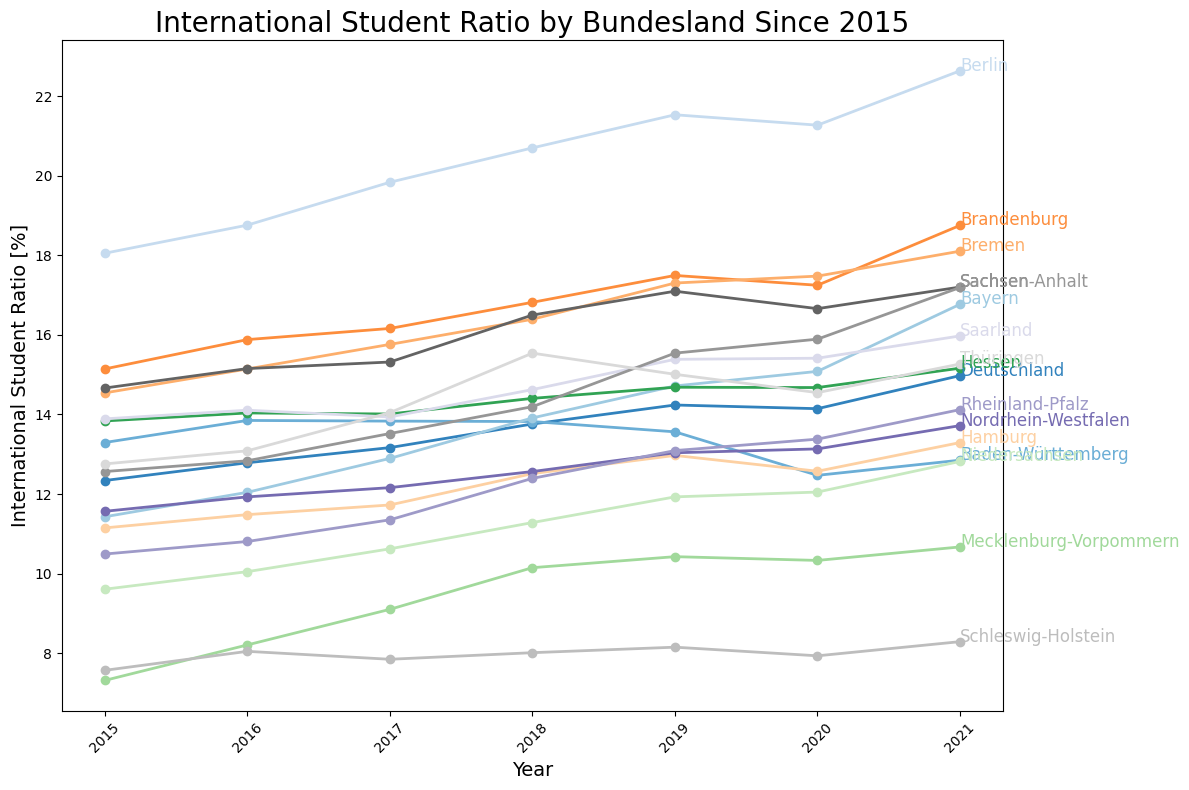

In [13]:
# define figure
fig, ax = plt.subplots(figsize=(12, 8))
# define the regions (Bundesländer)
regions = [
    "Deutschland",
    "Baden-Württemberg",
    "Bayern",
    "Berlin",
    "Brandenburg",
    "Bremen",
    "Hamburg",
    "Hessen",
    "Mecklenburg-Vorpommern",
    "Niedersachsen",
    "Nordrhein-Westfalen",
    "Rheinland-Pfalz",
    "Saarland",
    "Sachsen",
    "Sachsen-Anhalt",
    "Schleswig-Holstein",
    "Thüringen",
]

# define the colormap
cmap = plt.get_cmap("tab20c")
# henerate a color sequence based on the number of regions
colors = cmap(np.linspace(0, 1, len(regions)))

for i, region in enumerate(regions):
    plt.plot(
        ratio_international[ratio_international["Kreise und kreisfreie Städte"] == region].year,
        ratio_international[ratio_international["Kreise und kreisfreie Städte"] == region].ratio_international,
        label=region,
        marker="o",
        linewidth=2,
        color=colors[i],
    )
    # annotate the last point in the line plot with the region
    plt.text(
        ratio_international[ratio_international["Kreise und kreisfreie Städte"] == region].year.iloc[-1],
        ratio_international[ratio_international["Kreise und kreisfreie Städte"] == region].ratio_international.iloc[-1],
        region,
        fontsize=12,
        color=colors[i],
    )

# add titles and labels
ax.set_title("International Student Ratio by Bundesland Since 2015", fontsize=20)
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("International Student Ratio [%]", fontsize=14)

# enhance the legend
#ax.legend(title="Region", title_fontsize="13", fontsize="12", loc="upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Plot the Development of International Student Ratio on the Map of Germany

As mentioned before, we merge the DataFrame now with international student ratios with the geopandas DataFrame to visualize the data on the map of Germany.

In [14]:
gdf_merged = pd.merge(
    left=gdf,
    right=ratio_international[ratio_international["year"].isin([2015, 2018, 2020])],
    left_on="AGS",
    right_on="Amtlicher Gemeindeschlüssel (AGS)",
)

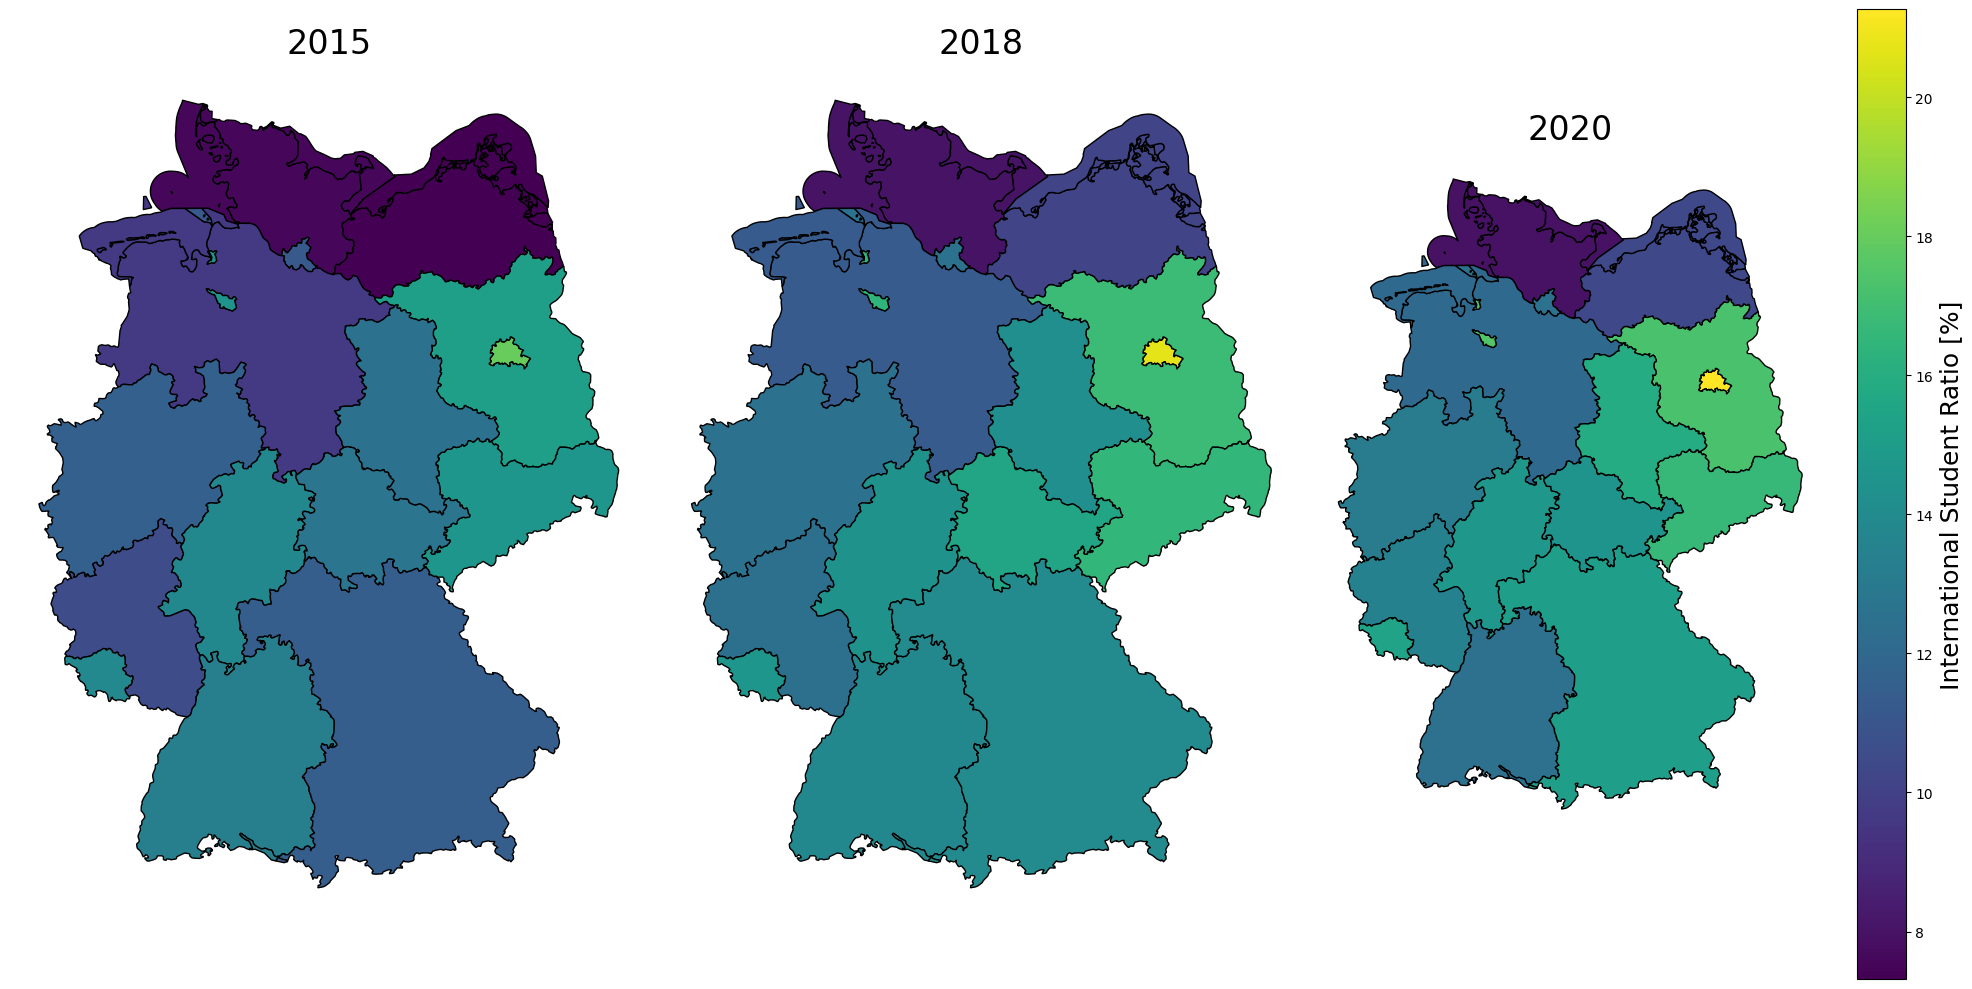

In [15]:
# get a sorted list of unique years
years = sorted(gdf_merged["year"].unique())
# get the global minimum and maximum of the ratio_international column
min_value = gdf_merged["ratio_international"].min()
max_value = gdf_merged["ratio_international"].max()

fig, axes = plt.subplots(1, len(years), figsize=(20, 10), sharex=True, sharey=True)

for ax, year in zip(axes, years):
    # filter the GeoDataFrame for the current year
    gdf_year = gdf_merged[gdf_merged["year"] == year]

    # plot the GeoDataFrame
    gdf_year.plot(
        ax=ax,
        column="ratio_international",
        legend=False,
        vmin=min_value,
        vmax=max_value,
        cmap="viridis",
        missing_kwds={"color": "lightgrey"},
        edgecolor="black",
    )
    # set title and turn off axis
    ax.set_title(year, fontsize=24)
    ax.axis("off")

# add a global colorbar
cm = fig.colorbar(
    plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min_value, vmax=max_value), cmap="viridis"), ax=axes[len(years) - 1]
)
cm.set_label("International Student Ratio [%]", fontsize=18)

# adjust the layout
plt.tight_layout()
plt.show()

## Visualization on the Level of Landkreise

In this second example, we will visualize the ratio of international students among students on the level of individual Landkreise. For this, we additionally need to load the map of Germany which outlines the individual Landkreise.

In [16]:
# load Kreise geopandas shapefile
path_to_data = "data/VG2500_KRS.shp"
gdf = geopandas.read_file(path_to_data)

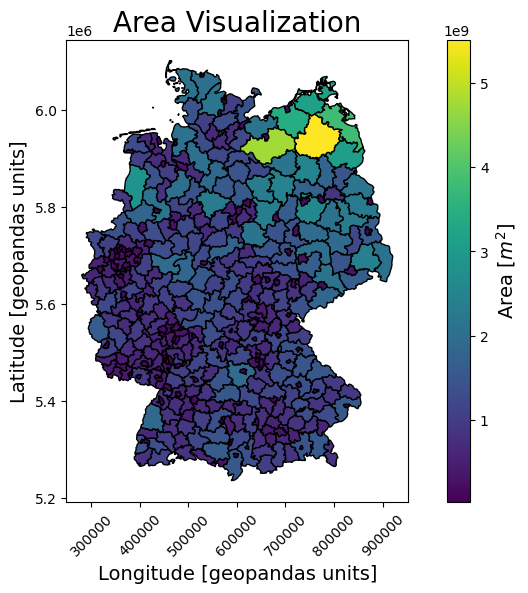

In [17]:
# plot the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
gdf.plot(column=gdf.area, legend=True, ax=ax, cmap="viridis", edgecolor="black")

# add titles and labels
ax.set_title("Area Visualization", fontsize=20)
ax.set_xlabel("Longitude [geopandas units]", fontsize=14)
ax.set_ylabel("Latitude [geopandas units]", fontsize=14)

# rotate x-axis labels to 45 degrees
plt.xticks(rotation=45)

# customize the colorbar
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel(r"Area [$m^2$]", fontsize=14)

plt.show()

In [18]:
gdf.GEN

0                 Flensburg
1                      Kiel
2                    Lübeck
3                Neumünster
4              Dithmarschen
               ...         
395     Saalfeld-Rudolstadt
396    Saale-Holzland-Kreis
397        Saale-Orla-Kreis
398                   Greiz
399        Altenburger Land
Name: GEN, Length: 400, dtype: object

In [19]:
# convert AGS (amtlicher Gemeindeschlüssel) to string
gdf.AGS = gdf.AGS.astype(str)
gdf.AGS

0      01001
1      01002
2      01003
3      01004
4      01051
       ...  
395    16073
396    16074
397    16075
398    16076
399    16077
Name: AGS, Length: 400, dtype: object

### Process Students Data

Now we can re-determine the ratio of international students among students per year and region. We will first look again at specific regions to see the time development of the ratio of international students among students before we then merge the DataFrame with the geopandas DataFrame to visualize the data on the map.

In [20]:
# calculate the ratio of international students in percent
ratio_international = (
    students.data[
        (students.data.Geschlecht == "Insgesamt") & (students.data["Fächergruppe (mit Insgesamt)"] == "Insgesamt")
    ]
    .groupby(by=["Kreise und kreisfreie Städte", "Amtlicher Gemeindeschlüssel (AGS)", "Semester"])[
        "Studierende_(im_Kreisgebiet)__Anzahl"
    ]
    .apply(lambda x: x.iloc[1] / x.iloc[0] if len(x) == 3 else None)  # filter to ensure that all 3 columns are present
) * 100
ratio_international.rename("ratio_international", inplace=True)
ratio_international

Kreise und kreisfreie Städte  Amtlicher Gemeindeschlüssel (AGS)  Semester  
      Aachen, Kreis           05354                              WS 2015/16          NaN
                                                                 WS 2016/17          NaN
                                                                 WS 2017/18          NaN
                                                                 WS 2018/19          NaN
                                                                 WS 2019/20          NaN
                                                                                 ...    
Deutschland                   DG                                 WS 2017/18    13.166464
                                                                 WS 2018/19    13.759918
                                                                 WS 2019/20    14.237081
                                                                 WS 2020/21    14.144582
                                  

In [21]:
# create a DataFrame with the ratio of international students
ratio_international = pd.DataFrame(ratio_international)
# add the year as a column
ratio_international["year"] = [int(semester[3:7]) for semester in ratio_international.index.get_level_values(2)]
# reset the index and sort the values in a time series manner
ratio_international = ratio_international.reset_index()
ratio_international = ratio_international.sort_values(["Kreise und kreisfreie Städte", "year"])
# remove leading whitespaces
ratio_international["Kreise und kreisfreie Städte"] = ratio_international["Kreise und kreisfreie Städte"].str.strip()

ratio_international.query("`Kreise und kreisfreie Städte` == 'Köln, kreisfreie Stadt'")

,Kreise und kreisfreie Städte,Amtlicher Gemeindeschlüssel (AGS),Semester,ratio_international,year
1540,"Köln, kreisfreie Stadt",05315,WS 2015/16,10.725453,2015
1541,"Köln, kreisfreie Stadt",05315,WS 2016/17,11.492824,2016
1542,"Köln, kreisfreie Stadt",05315,WS 2017/18,11.683984,2017
1543,"Köln, kreisfreie Stadt",05315,WS 2018/19,11.910545,2018
1544,"Köln, kreisfreie Stadt",05315,WS 2019/20,12.133971,2019
1545,"Köln, kreisfreie Stadt",05315,WS 2020/21,11.687422,2020
1546,"Köln, kreisfreie Stadt",05315,WS 2021/22,12.322888,2021


### Plot the Development of International Student Ratio for Köln and Aachen

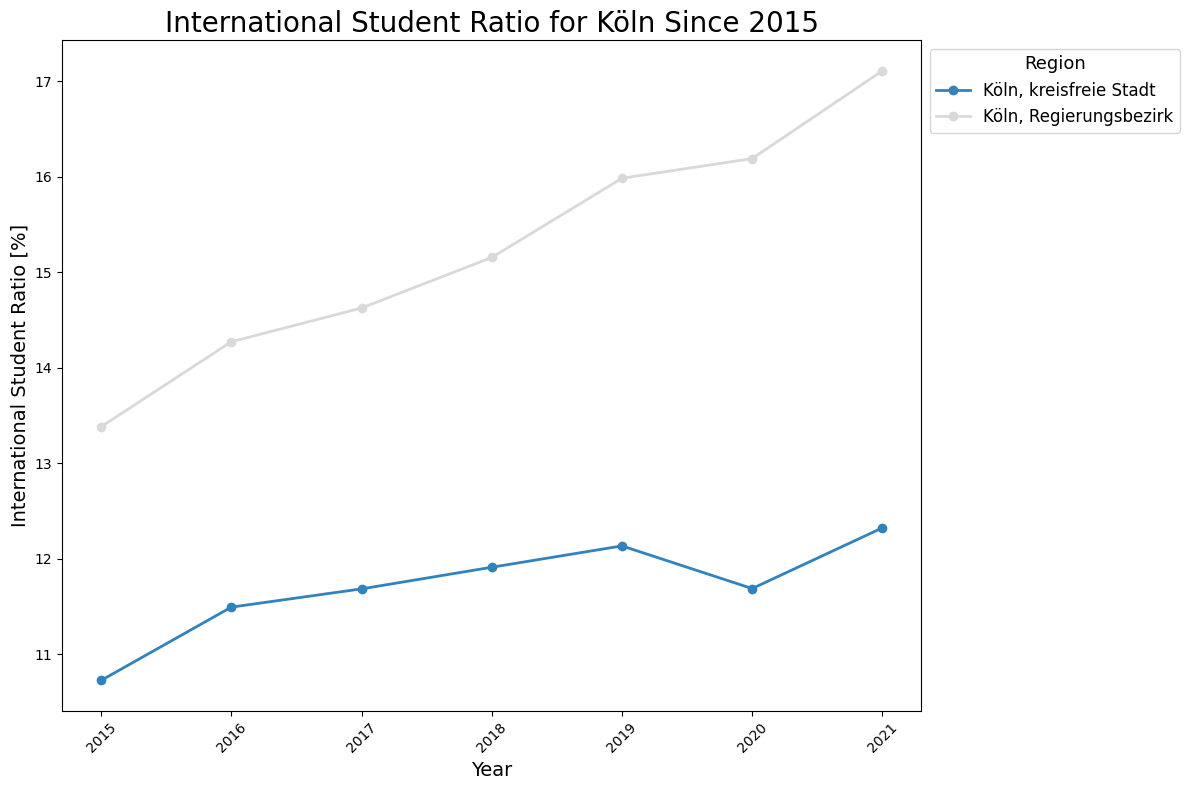

In [22]:
# define figure
fig, ax = plt.subplots(figsize=(12, 8))
# define the regions (Kreise und kreisfreie Städte)
regions = [
    "Köln, kreisfreie Stadt",
    "Köln, Regierungsbezirk",
]

# define the colormap
cmap = plt.get_cmap("tab20c")
# henerate a color sequence based on the number of regions
colors = cmap(np.linspace(0, 1, len(regions)))

for i, region in enumerate(regions):
    plt.plot(
        ratio_international[ratio_international["Kreise und kreisfreie Städte"] == region].year,
        ratio_international[ratio_international["Kreise und kreisfreie Städte"] == region].ratio_international,
        label=region,
        marker="o",
        linewidth=2,
        color=colors[i],
    )

# add titles and labels
ax.set_title("International Student Ratio for Köln Since 2015", fontsize=20)
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("International Student Ratio [%]", fontsize=14)

# enhance the legend
ax.legend(title="Region", title_fontsize="13", fontsize="12", loc="upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

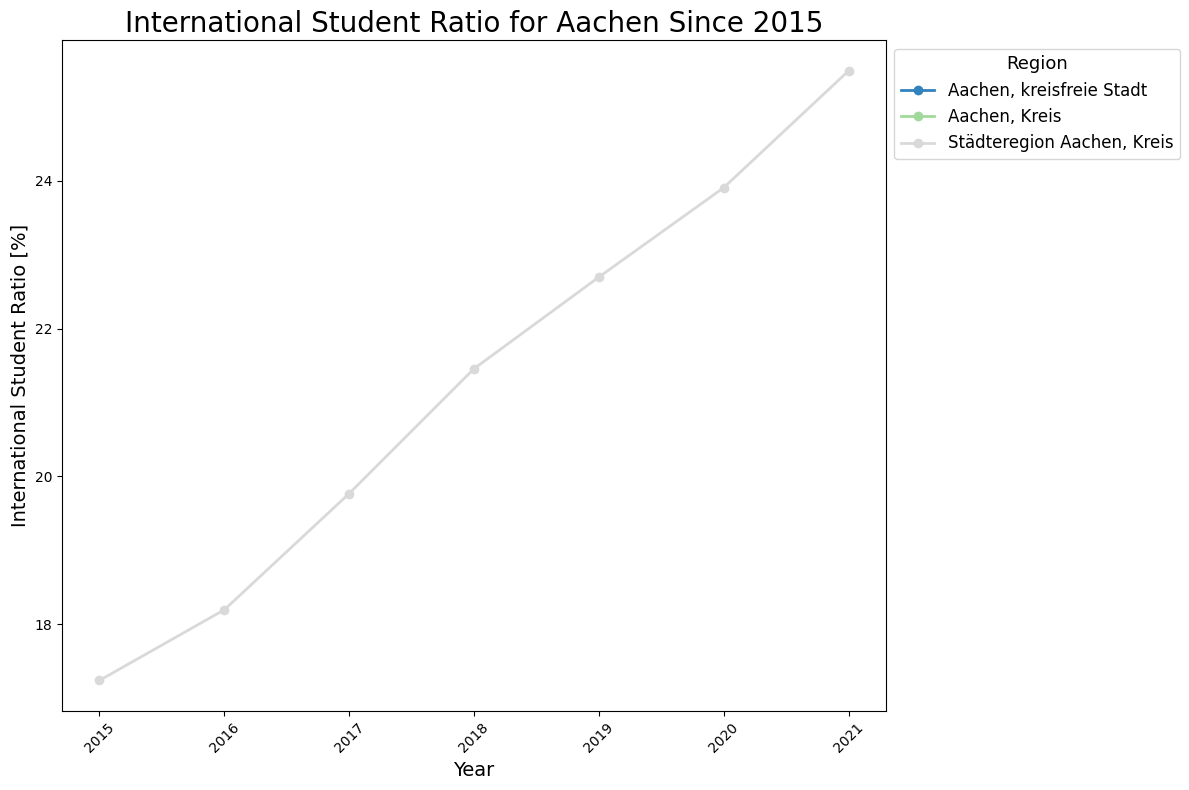

In [23]:
# define figure
fig, ax = plt.subplots(figsize=(12, 8))
# define the regions (Kreise und kreisfreie Städte)
regions = [
    "Aachen, kreisfreie Stadt",
    "Aachen, Kreis",
    "Städteregion Aachen, Kreis",
]

# define the colormap
cmap = plt.get_cmap("tab20c")
# henerate a color sequence based on the number of regions
colors = cmap(np.linspace(0, 1, len(regions)))

for i, region in enumerate(regions):
    plt.plot(
        ratio_international[ratio_international["Kreise und kreisfreie Städte"] == region].year,
        ratio_international[ratio_international["Kreise und kreisfreie Städte"] == region].ratio_international,
        label=region,
        marker="o",
        linewidth=2,
        color=colors[i],
    )

# add titles and labels
ax.set_title("International Student Ratio for Aachen Since 2015", fontsize=20)
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("International Student Ratio [%]", fontsize=14)

# enhance the legend
ax.legend(title="Region", title_fontsize="13", fontsize="12", loc="upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [24]:
ratio_international[ratio_international["Kreise und kreisfreie Städte"] == "Aachen, Kreis"]

,Kreise und kreisfreie Städte,Amtlicher Gemeindeschlüssel (AGS),Semester,ratio_international,year
0,"Aachen, Kreis",05354,WS 2015/16,NaN,2015
1,"Aachen, Kreis",05354,WS 2016/17,NaN,2016
2,"Aachen, Kreis",05354,WS 2017/18,NaN,2017
3,"Aachen, Kreis",05354,WS 2018/19,NaN,2018
4,"Aachen, Kreis",05354,WS 2019/20,NaN,2019
5,"Aachen, Kreis",05354,WS 2020/21,NaN,2020
6,"Aachen, Kreis",05354,WS 2021/22,NaN,2021


Having looked at the time development of the ratio of international students among students for specific regions shows a continues increase in the ratio of international students among students - in different strengths. However, it also shows that for example for `Aachen, Kreis`, there is no data available for all years in question.

### Investigating Missing Data and the Data Quality Parameter

A more detailed investigation of the `quality` parameter of the data would be necessary to potentially determine the reason for the missing data. While this is in principle supported by the API via `quality="on"`, regionalstatistik is the only of the three GENESIS databases to not actively support this. As a workaround, the website can be used to determine potential quality parameters of the data.

Looking at the data on the [website](https://www.regionalstatistik.de/genesis/online?operation=ergebnistabelleUmfang&levelindex=3&levelid=1719518083070&downloadname=21311-01-01-4#abreadcrumb) reveals that there are indeed no values for `Aachen, Kreis` (more specifically, "-" means "nichts vorhanden"), while the data for `Aachen, kreisfreie Stadt` is unknown or to be kept secret ("." means "Zahlenwert unbekannt oder geheimzuhalten").

(Explanation of legend [here](https://www.regionalstatistik.de/genesis/online?operation=ergebnistabelleQualitaet&language=de&levelindex=3&levelid=1719518083070#abreadcrumb))

### Plot the Development of International Student Ratio on the Map of Germany With Finer Granularity

As before we merge the DataFrame with international student ratios with the geopandas DataFrame to visualize the data on the map of Germany. However, this time we will visualize the data on the level of individual Landkreise.

In [25]:
gdf_merged = pd.merge(left=gdf, right=ratio_international, left_on="AGS", right_on="Amtlicher Gemeindeschlüssel (AGS)")
gdf_merged.ratio_international

0       5.445491
1       5.879847
2       6.071910
3       6.458591
4       7.097041
          ...   
2781         NaN
2782         NaN
2783         NaN
2784         NaN
2785         NaN
Name: ratio_international, Length: 2786, dtype: float64

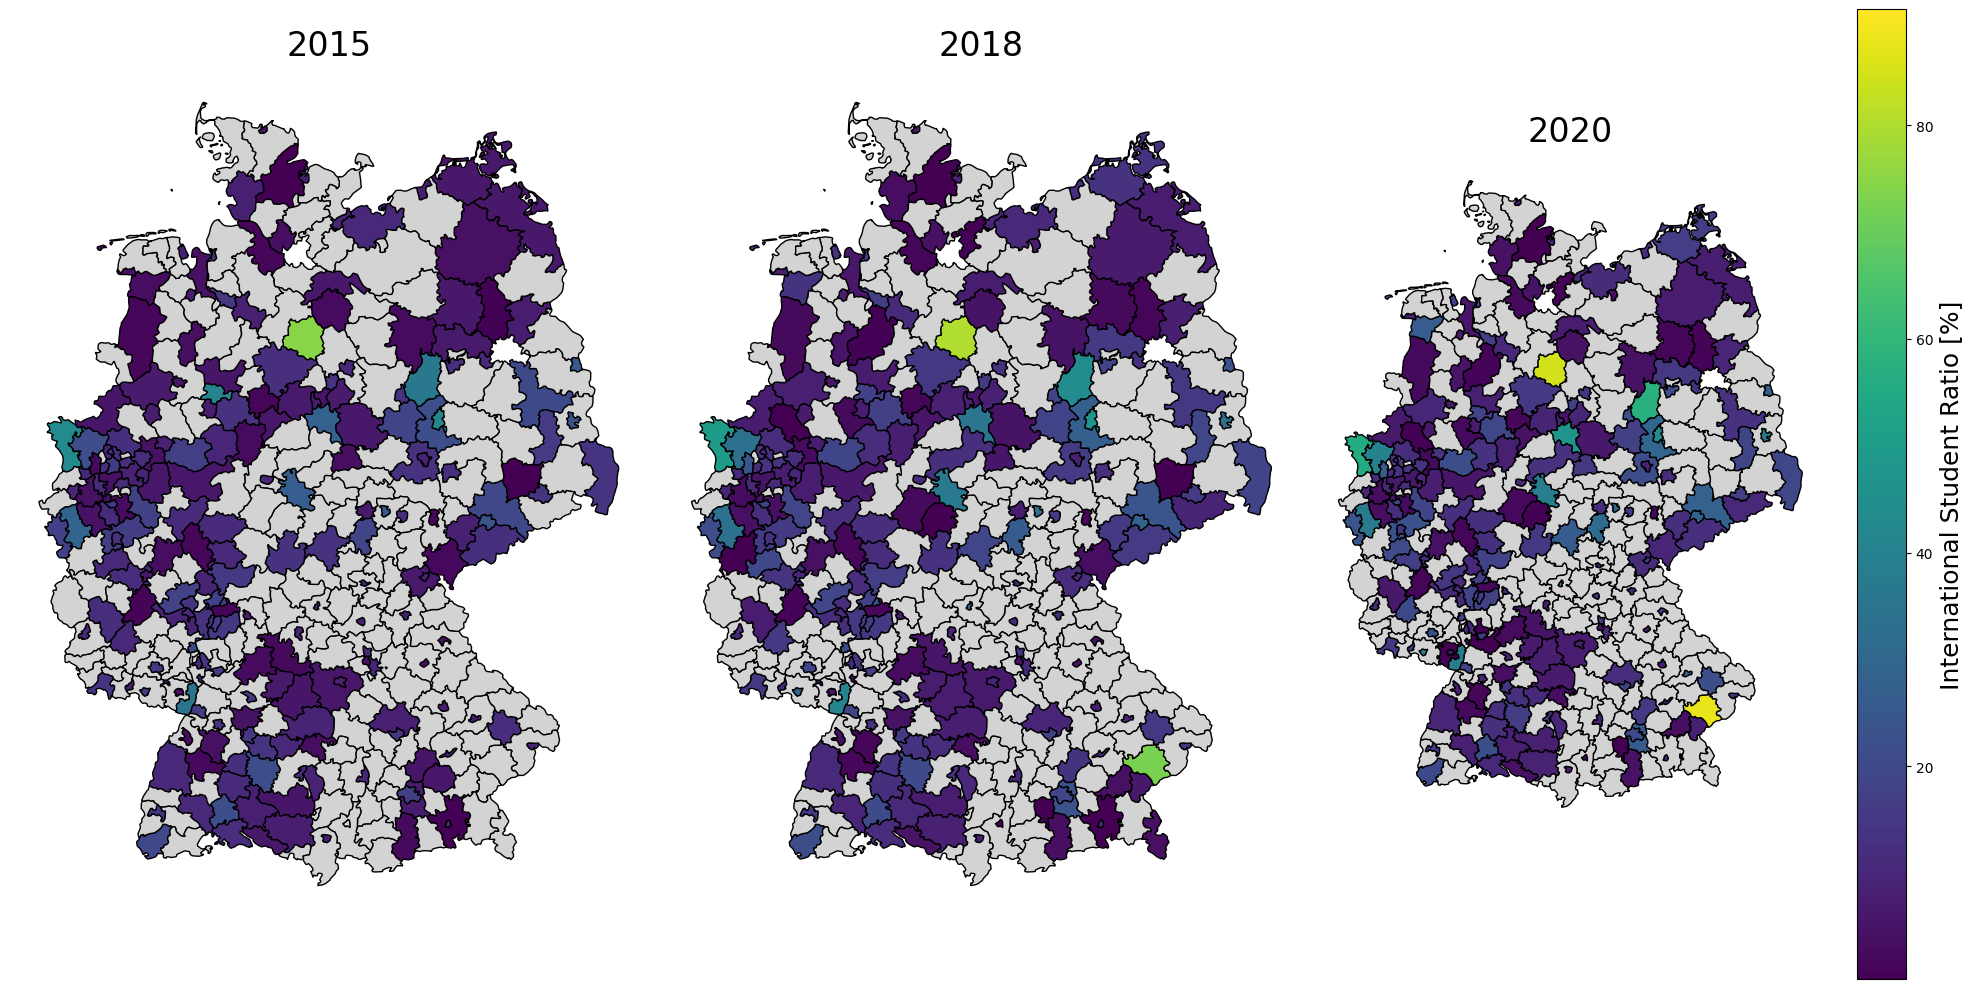

In [26]:
# get a sorted list of unique years
years = [2015, 2018, 2020]

for year_to_check in years:
    assert ratio_international["year"].isin([year_to_check]).any()

# get the global minimum and maximum of the ratio_international column
min_value = gdf_merged["ratio_international"].min()
max_value = gdf_merged["ratio_international"].max()

fig, axes = plt.subplots(1, len(years), figsize=(20, 10), sharex=True, sharey=True)

for ax, year in zip(axes, years):
    # filter the GeoDataFrame for the current year
    gdf_year = gdf_merged[gdf_merged["year"] == year]

    # plot the GeoDataFrame
    gdf_year.plot(
        ax=ax,
        column="ratio_international",
        legend=False,
        vmin=min_value,
        vmax=max_value,
        cmap="viridis",
        missing_kwds={"color": "lightgrey"},
        edgecolor="black",
    )
    # set title and turn off axis
    ax.set_title(year, fontsize=24)
    ax.axis("off")

# add a global colorbar
cm = fig.colorbar(
    plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min_value, vmax=max_value), cmap="viridis"), ax=axes[len(years) - 1]
)
cm.set_label("International Student Ratio [%]", fontsize=18)

# adjust the layout
plt.tight_layout()
plt.show()

As seen for the example of Aachen, there are a lot of missing values for specific regions - either due to a lack of data or due to the data being unknown or to be kept secret. This is important to keep in mind when working with any kind of GENESIS the data.